# Double-q learning
An example

In [1]:
import agents
import numpy as np
import matplotlib.pyplot as plt

from numba import njit, prange

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
map_states = {
    "A": 0,
    "B": 1,
}

map_actions = {
    "left": 0,
    "right": 1,
}

In [4]:
n_arms_B = 10
rewards = np.random.normal(loc=-0.1, scale=1, size=n_arms_B)

In [5]:
@njit
def step(state, action):
    if state == 0:
        reward = 0
        if action == 1: # right
            new_state = -1 # terminal state
        if action == 0: # left
            new_state = 1

    if state == 1:
        new_state = -1 # terminal state
        reward = np.random.normal(loc=-0.1, scale=1.0)
        # reward = rewards[action]

    return new_state, reward


@njit
def q_step(state, Q, epsilon, alpha, gamma):
    action = agents.choose_action(state, Q, epsilon)
    new_state, reward = step(state, action)
    
    q_new = Q[state][action] + alpha * (reward + gamma * Q[new_state].max() - Q[state][action])

    # if at terminal state, return to A
    if new_state == -1:
        new_state = 0
        
    return (new_state, action), q_new


@njit
def doubleq_step(state, Q, epsilon, alpha, gamma):
    choice = np.random.uniform() < 0.5
    Q1 = Q[choice]
    Q2 = Q[1 - choice]
    
    Qmid = [(q1 + q2) / 2 for q1, q2 in zip(Q1, Q2)]
    action = agents.choose_action(state, Qmid, epsilon)
    new_state, reward = step(state, action)

    qnew = Q1[state][action] + alpha *  (reward + gamma * Q2[new_state][Q1[new_state].argmax()] - Q1[state][action])
    Q1[state][action] = q_new

    # return to state A if at terminal state
    # TODO: move to main loop
    if new_state == -1:
        new_state = 0

    return (new_state, action), Q


@njit
def run_and_count(n_episodes, n_arms_B, alpha, epsilon, gamma, qfn):
    state = 0 # A
    n_steps_A = 0

    Q = (
        np.zeros(2,), # left, right actions
        np.zeros(n_arms_B,),
        np.zeros(1,) # terminal state
    )
    
    actions_in_A = np.zeros(n_episodes)
    while n_steps_A != n_episodes:
        (state_new, action), q_new = qfn(state, Q, epsilon, alpha, gamma)

        if state == 0:
            actions_in_A[n_steps_A] = action
            n_steps_A += 1

        Q[state][action] = q_new
        state = state_new

    return Q, actions_in_A



def run_and_count_sims(n_sims, n_episodes, n_arms_B, alpha, epsilon, gamma, qfn):
    sims_actions_in_A = np.zeros((n_sims, n_episodes))
    for i in prange(n_sims):
        _, actions_in_A = run_and_count(n_episodes, n_arms_B, alpha, epsilon, gamma, qfn)
        sims_actions_in_A[i] = actions_in_A

    return sims_actions_in_A

In [6]:
n_arms_B = 10
n_episodes = 300
alpha, epsilon, gamma = 0.1, 0.1, 1.0

Qv, actions_in_A = run_and_count(n_episodes, n_arms_B, alpha, epsilon, gamma, q_step)

In [7]:
n_sims = 1000
sims_actions_in_A = run_and_count_sims(n_sims, n_episodes, n_arms_B, alpha, epsilon, gamma, q_step)

Text(0, 0.5, '% left\nactions\nfrom A')

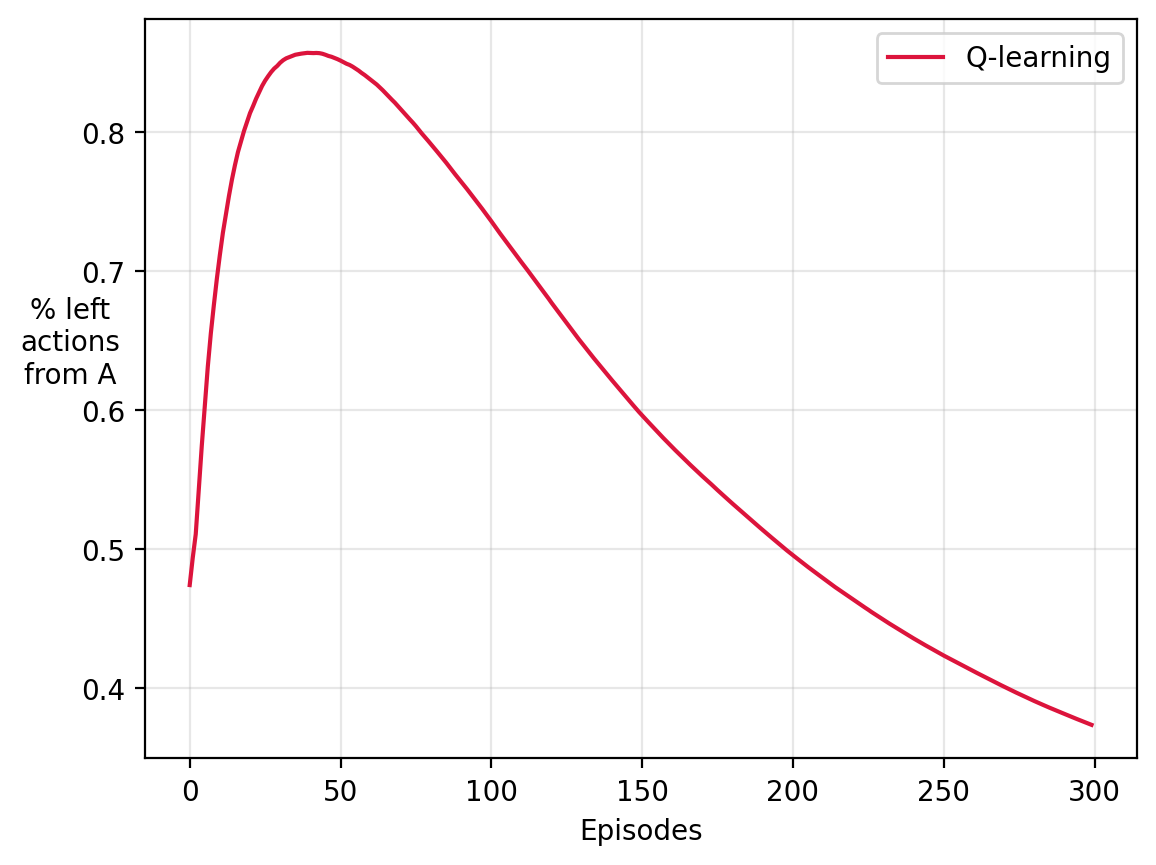

In [8]:
cumulative_episodes = np.ones(n_episodes).cumsum()
prop_left_sims = (1 - sims_actions_in_A).cumsum(axis=1) / cumulative_episodes[None, :]
plt.plot(prop_left_sims.mean(axis=0), c="crimson", label="Q-learning")
plt.grid(alpha=0.3)
plt.xlabel("Episodes")
plt.legend()
plt.ylabel("% left\nactions\nfrom A", rotation=0)